## Solving Galactic Diffusion Equation using Crank Nicholson (W/O Ghost Zones)

This notebook will illustrate the crank nicholson difference method solving Galactic Dynamo Diffusion Equation.

The implicit Crank-Nicolson difference equation of the Dynamo equation is derived by discretizing the following coupled equations

$$
\frac{\partial \bar{B}_r}{\partial t} = \eta_t\frac{\partial^2 \bar{B}_r}{\partial z^2}
$$

$$
\frac{\partial \bar{B}_\phi}{\partial t} = \eta_t \frac{\partial^2 \bar{B}_\phi}{\partial z^2} 
$$

Where $\eta_t$ is currently constant parameter called the magnetic diffusivity.

In [1]:
import numpy as np
import tabulate
from PIL import Image

import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from IPython import display

from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = 0.5
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Discrete Grid

1. **Spatial Discretization**:

   We divide the spatial domain  $z$ into $N$ grid points. Let $h$ denote the spacing between consecutive grid points.

2. **Time Discretization**:

   We discretize the time domain $t$ into time steps of size $k$.

The region $\Omega$ is discretised into a uniform mesh $\Omega_h$. In the space $x$ direction into $N$ steps giving a stepsize of

$$ h=\frac{1-0}{N} $$
resulting in 

$$ x[i]=0+ih, \ \ \  i=0,1,...,N, $$

and into $N_t$ steps in the time $t$ direction giving a stepsize of

$$ k=\frac{1-0}{N_t} $$
resulting in 

$$ t[i]=0+ik, \ \ \ k=0,...,K.$$
The Figure below shows the discrete grid points for $N$ space points and $N_t$ time points , the <font color = 'red'> <b>red</b> </font> dots are the unknown values, the <font color = 'green'> <b>green</b> </font> dots are the known boundary conditions and the <font color = 'blue'> <b>blue</b> </font> dots are the known initial conditions of the diffusion Equation.

In [2]:
N = 2000
Nt = 400
h = 2 / N
k = 2 / Nt
r = k / (h * h)
eta_t = 1 # diffusion coefficient
time_steps = 50
time = np.arange(0, (time_steps + 0.5) * k, k)
z = np.arange(-1.00, 1.0001, h)  
Z, Y = np.meshgrid(z, time)

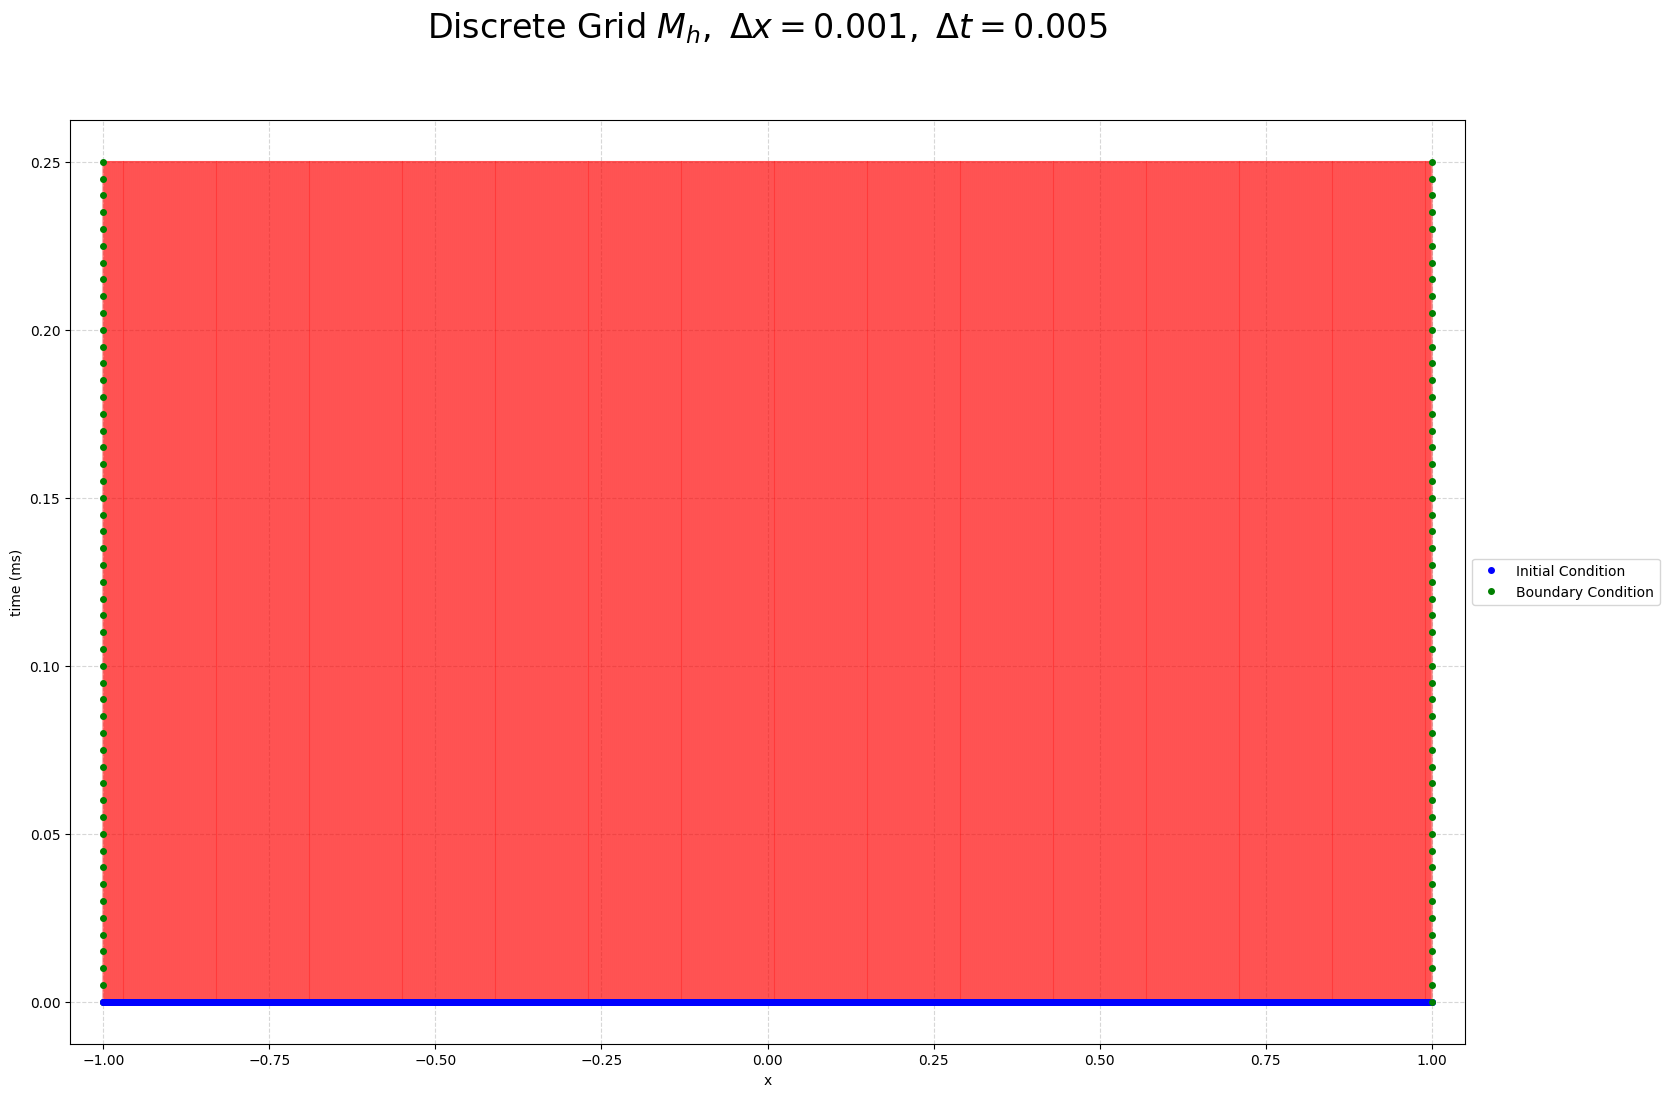

In [3]:
fig = plt.figure(figsize=(18, 12))
plt.plot(Z, Y, 'r-', alpha=0.3)  
plt.plot(z, 0 * z, 'bo', markersize=4, label='Initial Condition')  
plt.plot(np.ones(time_steps + 1) * -1, time, 'go', markersize=4, label='Boundary Condition')  
plt.plot(z, 0 * z, 'bo', markersize=4)
plt.plot(np.ones(time_steps + 1) * 1, time, 'go', markersize=4)
plt.xlim((-1.05, 1.05))  
plt.xlabel('x')
plt.ylabel('time (ms)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Discrete Grid $M_h,$ $\Delta x= %s,$ $\Delta t=%s$' % (h, k), fontsize=24, y=1.08)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("seed_10/grid.pdf")
plt.show()

## Initial and Boundary Conditions

### Vacuum Boundary Conditions

At $|z| = h$ for a disc-shaped magnetized system, continuity of magnetic field components requires $B_{\phi} = 0$ and $B_r \approx 0$ at $z = \pm h$. These exact conditions, known as *vacuum boundary conditions*, are due to axial symmetry and the outer magnetic field's potential structure.

### Discrete Initial and Boundary Conditions

Discrete initial conditions: $ B[i,0] = B_o \cos(\gamma z[i]) $.

Discrete boundary conditions: 

$$ B[0,j] = 0, \quad B[N,j] = 0 $$

Here, $B[i,j]$ represents the numerical approximation of $B(x[i],t[j])$. We employ the exact eigensolution for $B$ at $t=0$, ensuring physical accuracy. The figure below displays $B[i,0]$ for the initial (blue) and boundary (red) conditions at $t[0]=0$.

In [4]:
def generate_random_Bo(seed_value):
    np.random.seed(seed_value)  
    random_float = np.random.rand()  
    return random_float

def initial_conditions(N, time_steps, seed_value, m, n, BCtype = "vacuum"):
    mag_br = generate_random_Bo(seed_value)
    mag_bphi = generate_random_Bo(seed_value + 1)  
    
    z = np.linspace(-1, 1, N+1)
    Br = np.zeros((N+1, time_steps+1))
    Bphi = np.zeros((N+1, time_steps+1))
    b1 = np.zeros(N-1)
    b2 = np.zeros(N-1)
    
    # Initial Condition for Br and Bphi
    for i in range(1, N+1):
        Br[i, 0] = 1000*mag_br * np.cos((m + 1/2) * np.pi * z[i])
        Bphi[i, 0] = 1000*mag_bphi * np.cos((n + 1/2)* np.pi * z[i])
    
    # Boundary Condition
    if BCtype == "vacuum":
        Br[0, :] = 0
        Bphi[0, :] = 0
        Br[N, :] = 0
        Bphi[N, :] = 0

    return z, Br, Bphi, b1, b2, mag_br, mag_bphi

In [5]:
seed_value = 10
m, n = 1, 0
z, Br, Bphi, b1, b2, mag_br, mag_bphi = initial_conditions(N, time_steps, seed_value, m, n)

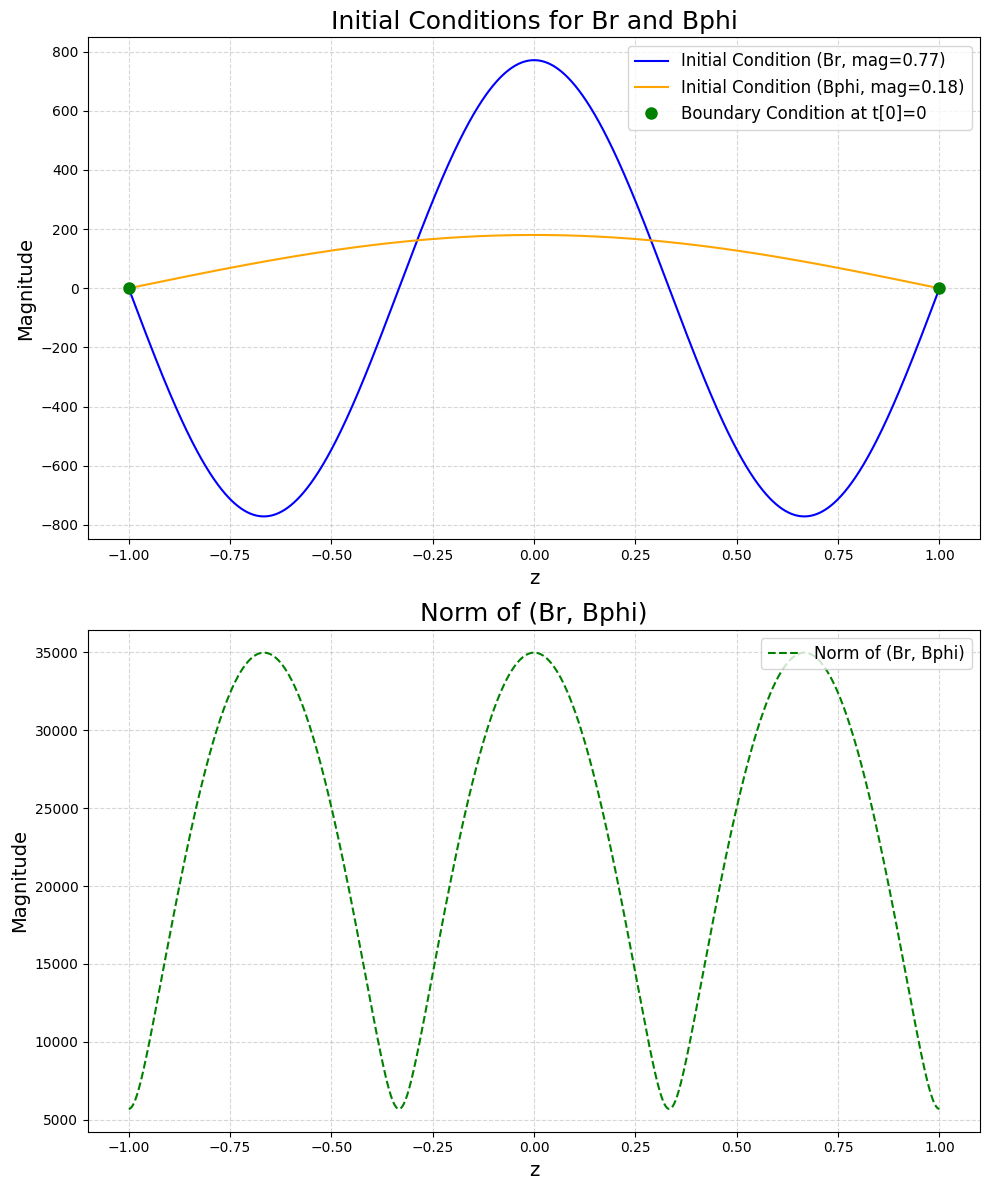

In [6]:
fig, axs = plt.subplots(2, figsize=(10, 12))

axs[0].plot(z, Br[:, 0], label=f'Initial Condition (Br, mag={mag_br:.2f})', color='blue')
axs[0].plot(z, Bphi[:,0], label=f'Initial Condition (Bphi, mag={mag_bphi:.2f})', color='orange')
axs[0].plot(z[[0, N]], Br[[0, N], 0], 'go', markersize=8, label='Boundary Condition at t[0]=0')
axs[0].set_title('Initial Conditions for Br and Bphi', fontsize=18)
axs[0].set_xlabel('z', fontsize=14)
axs[0].set_ylabel('Magnitude', fontsize=14)
axs[0].legend(loc='upper right', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.5)


norm_Br_Bphi = [np.linalg.norm(np.sqrt(Br[i, 0]**2 + Bphi[:,0]**2)) for i in range(len(z))]
axs[1].plot(z, norm_Br_Bphi , label='Norm of (Br, Bphi)', linestyle='--', color='green')
axs[1].set_title('Norm of (Br, Bphi)', fontsize=18)
axs[1].set_xlabel('z', fontsize=14)
axs[1].set_ylabel('Magnitude', fontsize=14)
axs[1].legend(loc='upper right', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("seed_10/initial_conditions.pdf")
plt.show()

## Discretized Equations

Using finite difference approximations, we discretize the time derivatives and the second-order spatial derivatives in the given PDEs.

Let $B_i$ represent $B_r$ and $B_\phi$ for $i = 1, 2, \ldots, N$.

The discretized equations for $B_i$ and $B_{N+i}$ are:

- For $B_r$:
    $$
    \frac{B_i^{j+1} - B_i^{j}}{k} = \eta_t \frac{1}{2} \left( \frac{B_{i-1}^{j+1} - 2B_{i}^{j+1} + B_{i+1}^{j+1} + B_{i-1}^{j} - 2B_{i}^{j} + B_{i+1}^{j}}{h^2} \right)
    $$

- For $B_\phi$:
    $$
    \frac{B_{N+i}^{j+1} - B_{N+i}^{j}}{k} = \eta_t \frac{1}{2} \left( \frac{B_{N+i-1}^{j+1} - 2B_{N+i}^{j+1} + B_{N+i+1}^{j+1} + B_{N+i-1}^{j} - 2B_{N+i}^{j} + B_{N+i+1}^{j}}{h^2} \right)
    $$


We could redefine a few parameters for the ease of this matrix representation. They are the following:

$$ \alpha = \frac{\eta_t k}{2 h^2} $$

After rearranging $j + 1$ terms on one side and $j$ terms on the other side of the equation, we get the following sets of linear equations:

$$
-\alpha U_{i-1j+1} + ( 2 + 2\alpha)U_{ij+1} - \alpha U_{i+1j+1} = \alpha U_{i-1j} + (2-2\alpha)U_{ij} + \alpha U_{i+1j}
$$

$$
(2I + \alpha B)\mathbf{U}_{j} = (2I - \alpha B)\mathbf{U}_{j-1} +\mathbf{b}_{j}+\mathbf{b}_{j+1} 
$$

for which $A$ is a $N-2 \times N-2$ matrix:

$$
(2I + \alpha B) = \begin{pmatrix}
2+2\alpha & -\alpha & 0 & 0 & 0 & 0 & 0 & 0 \\
-\alpha & 2+2\alpha & -\alpha & 0 & 0 & 0 & 0 & 0 \\
0 & -\alpha & 2+2\alpha & -\alpha & 0 & 0 & 0 & 0 \\
0 & 0 & -\alpha & 2+2\alpha & -\alpha & 0 & 0 & 0 \\
0 & 0 & 0 & -\alpha & 2+2\alpha & -\alpha & 0 & 0 \\
0 & 0 & 0 & 0 & -\alpha & 2+2\alpha & -\alpha & 0 \\
0 & 0 & 0 & 0 & 0 & -\alpha & 2+2\alpha & -\alpha \\
0 & 0 & 0 & 0 & 0 & 0 & -\alpha & 2+2\alpha \\
\end{pmatrix}
$$

$B$ is another $N-2 \times N-2$ matrix:

$$
(2I - \alpha B) = \begin{pmatrix}
2-2\alpha & \alpha & 0 & 0 & 0 & 0 & 0 & 0 \\
\alpha & 2-2\alpha & \alpha & 0 & 0 & 0 & 0 & 0 \\
0 & \alpha & 2-2\alpha & \alpha & 0 & 0 & 0 & 0 \\
0 & 0 & \alpha & 2-2\alpha & \alpha & 0 & 0 & 0 \\
0 & 0 & 0 & \alpha & 2-2\alpha & \alpha & 0 & 0 \\
0 & 0 & 0 & 0 & \alpha & 2-2\alpha & \alpha & 0 \\
0 & 0 & 0 & 0 & 0 & \alpha & 2-2\alpha & \alpha \\
0 & 0 & 0 & 0 & 0 & 0 & \alpha & 2-2\alpha \\
\end{pmatrix}
$$

$\mathbf{U}_j$ is a column vector of size N-2 containing $U_{ij}$ values, $\mathbf{b}_j$ and $\mathbf{b}_{j+1}$ are column vectors of size N-2 representing the boundary conditions for the current and next time steps, respectively.

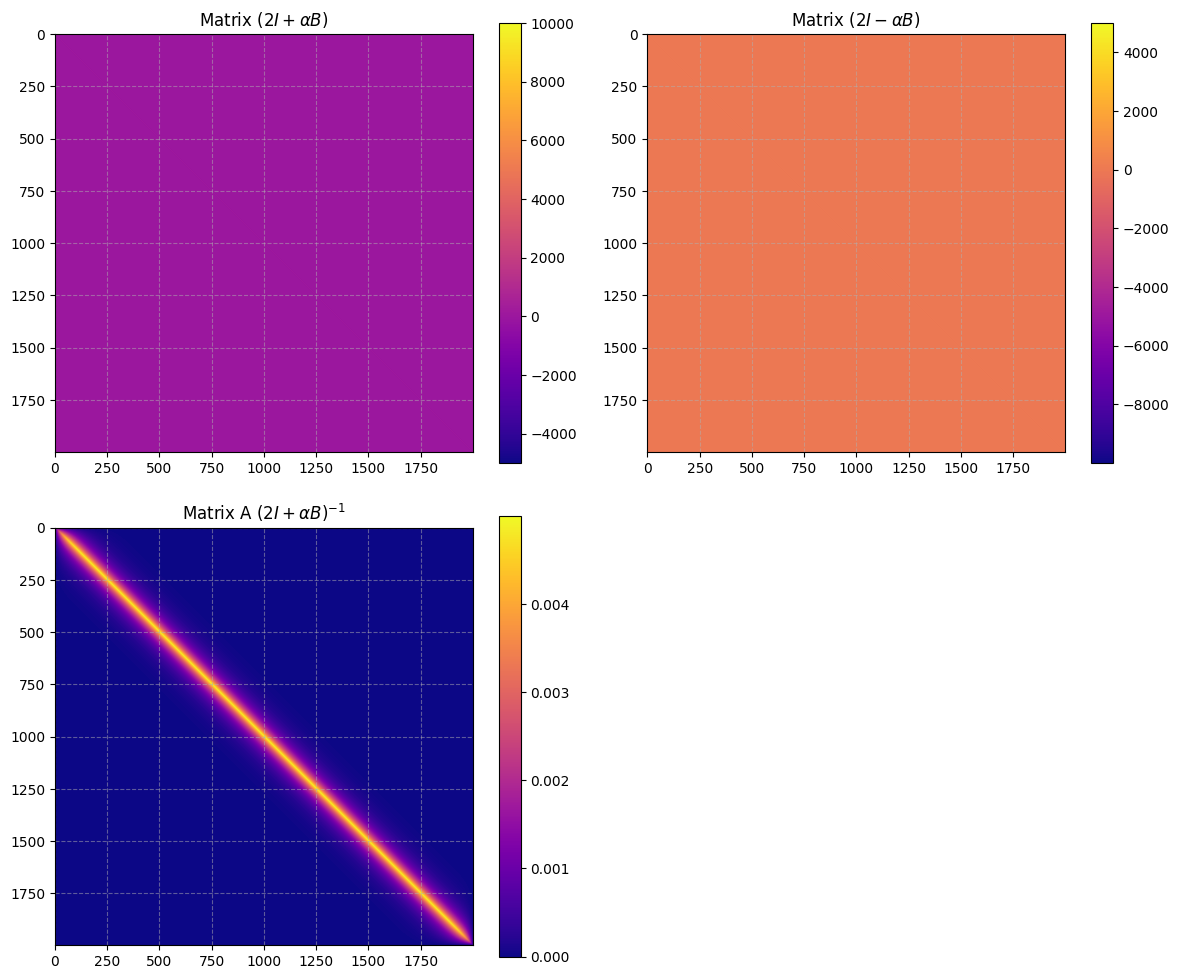

In [7]:
#  A and B
A = np.zeros((N-1, N-1))
B = np.zeros((N-1, N-1))
for i in range(N-1):
    A[i, i] = 2 + 2 * r
    B[i, i] = 2 - 2 * r
    if i < N-2:
        A[i, i+1] = -r
        A[i+1, i] = -r
        B[i, i+1] = r
        B[i+1, i] = r

# inverse of A
A_inv = np.linalg.inv(A)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im = axs[0, 0].imshow(A, cmap='plasma')
axs[0, 0].set_title(r'Matrix $(2I + \alpha B)$')
plt.colorbar(im, ax=axs[0, 0])
im = axs[0, 1].imshow(B, cmap='plasma')
axs[0, 1].set_title(r'Matrix $(2I - \alpha B)$')
plt.colorbar(im, ax=axs[0, 1])
im = axs[1, 0].imshow(A_inv, cmap='plasma')
axs[1, 0].set_title(r'Matrix A $(2I + \alpha B)^{-1}$')
plt.colorbar(im, ax=axs[1, 0])
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig("seed_10/matrix_A_B_A_inv.pdf")
plt.show()

In [8]:
for j in range (1,time_steps+1):
    b1[0]=r*Br[0,j-1]+r*Br[0,j]
    b1[N-2]=r*Br[N,j-1]+r*Br[N,j]
    v1=np.dot(B,Br[1:(N),j-1])
    Br[1:(N),j]=np.dot(A_inv,v1+b1)
    
    b2[0]=r*Bphi[0,j-1]+r*Bphi[0,j]
    b2[N-2]=r*Bphi[N,j-1]+r*Bphi[N,j]
    v2=np.dot(B,Bphi[1:(N),j-1])
    Bphi[1:(N),j]=np.dot(A_inv,v2+b2)

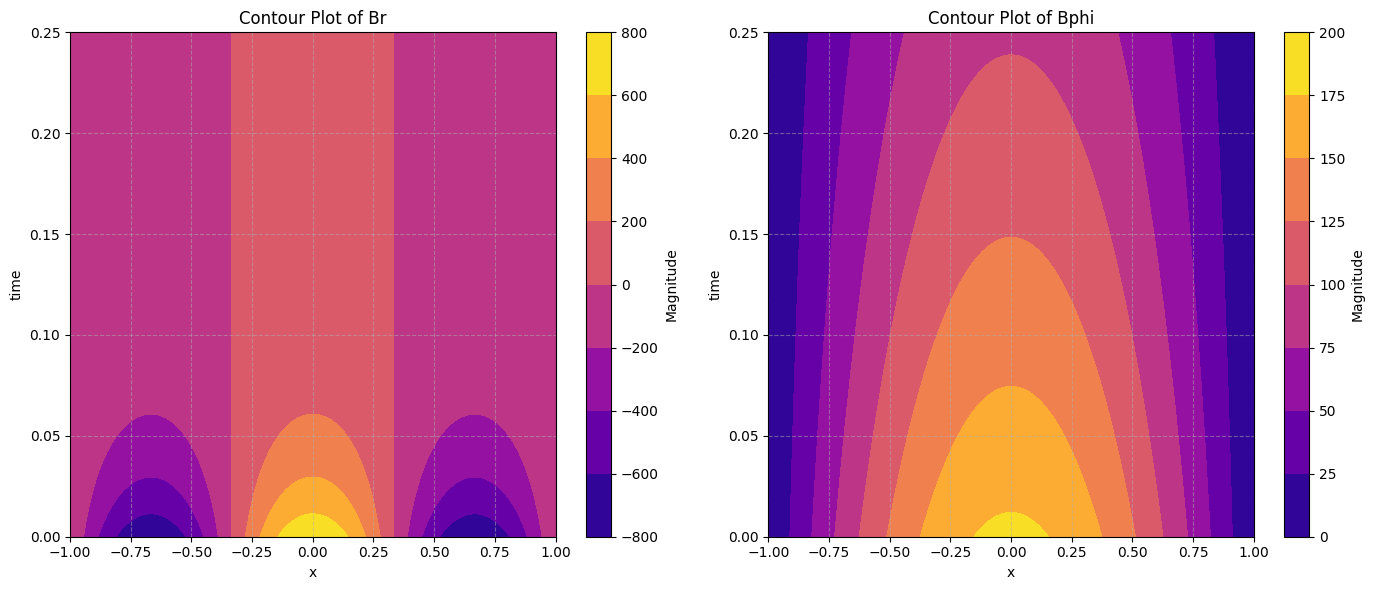

In [9]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.contourf(Z, Y, Br.transpose(), cmap='plasma')
plt.colorbar(label='Magnitude')
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Br')

plt.subplot(1, 2, 2)
plt.contourf(Z, Y, Bphi.transpose(), cmap='plasma')
plt.colorbar(label='Magnitude')
plt.xlabel('x')
plt.ylabel('time')
plt.title('Contour Plot of Bphi')

plt.tight_layout()
plt.savefig("seed_10/contour_plot_Br_Bphi.pdf")
plt.show()

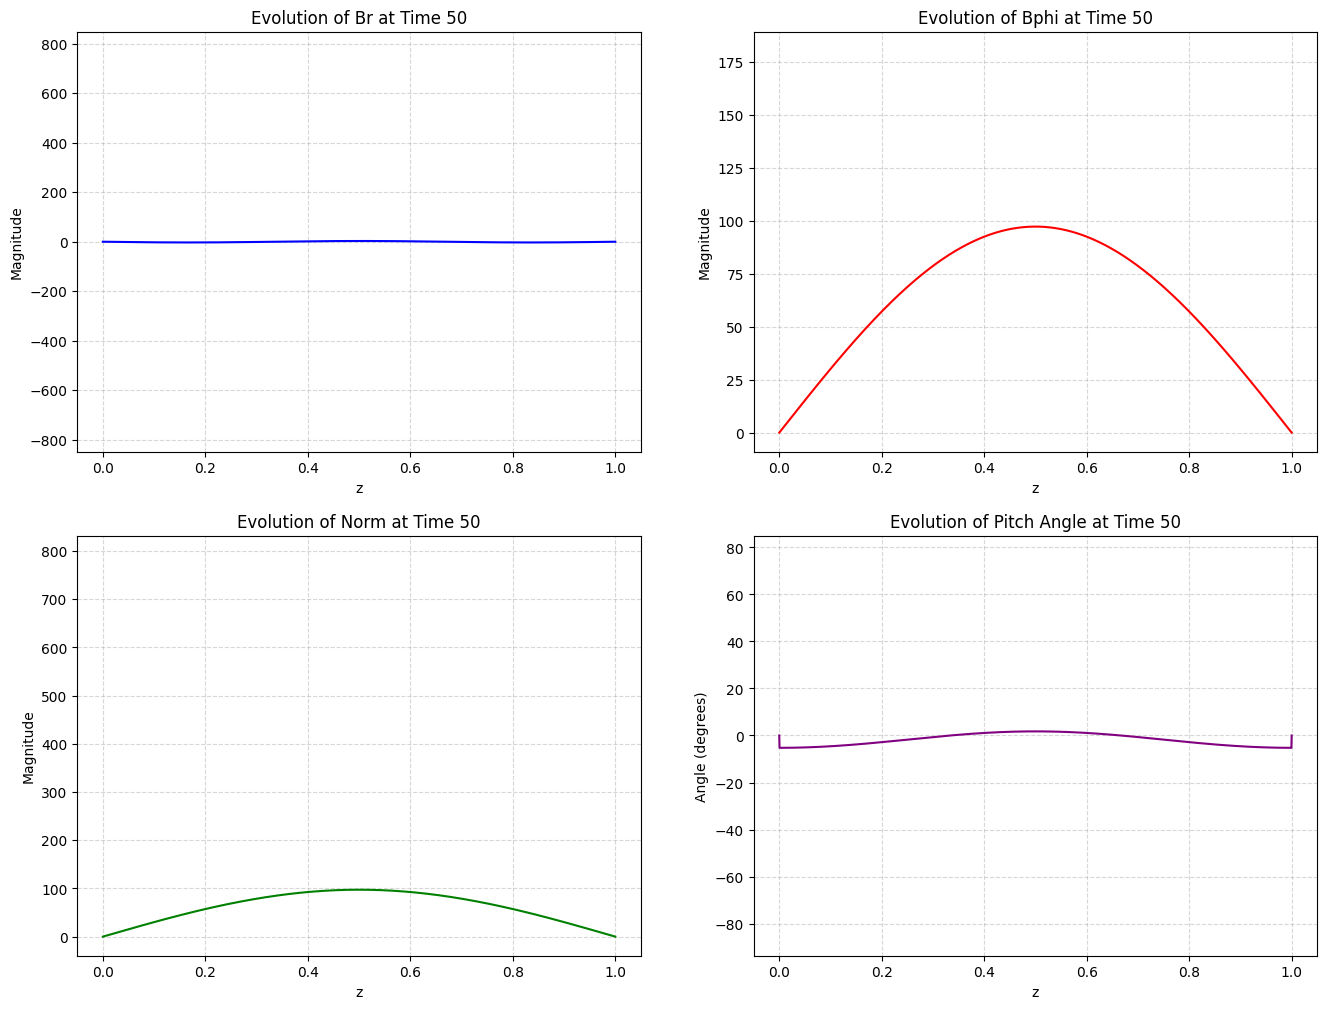

In [10]:
norm_squared_sum = np.sqrt(Br**2 + Bphi**2)
pitch_angle = np.arctan2(Br, Bphi) * (180 / np.pi)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# Plot Br
line_br, = axs[0, 0].plot(np.linspace(0, 1, Br.shape[0]), Br[:, 0], color='blue', label='Br')
axs[0, 0].set_xlabel('z')
axs[0, 0].set_ylabel('Magnitude')
axs[0, 0].set_title('Evolution of Br')

# Plot Bphi
line_bphi, = axs[0, 1].plot(np.linspace(0, 1, Bphi.shape[0]), Bphi[:, 0], color='red', label='Bphi')
axs[0, 1].set_xlabel('z')
axs[0, 1].set_ylabel('Magnitude')
axs[0, 1].set_title('Evolution of Bphi')

# Plot Norm
line_norm, = axs[1, 0].plot(np.linspace(0, 1, norm_squared_sum.shape[0]), norm_squared_sum[:, 0], color='green', label='Norm')
axs[1, 0].set_xlabel('z')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].set_title('Evolution of Norm')


line_pitch, = axs[1, 1].plot(np.linspace(0, 1, pitch_angle.shape[0]), pitch_angle[:, 0], color='purple', label='Pitch Angle')
axs[1, 1].set_xlabel('z')
axs[1, 1].set_ylabel('Angle (degrees)')
axs[1, 1].set_title('Evolution of Pitch Angle')

def update(frame):
    line_br.set_ydata(Br[:, frame])
    axs[0, 0].set_title(f'Evolution of Br at Time {frame}')
    
    line_bphi.set_ydata(Bphi[:, frame])
    axs[0, 1].set_title(f'Evolution of Bphi at Time {frame}')
    
    line_norm.set_ydata(norm_squared_sum[:, frame])
    axs[1, 0].set_title(f'Evolution of Norm at Time {frame}')
    
    line_pitch.set_ydata(pitch_angle[:, frame])
    axs[1, 1].set_title(f'Evolution of Pitch Angle at Time {frame}')
    
    return line_br, line_bphi, line_norm, line_pitch

ani = FuncAnimation(fig, update, frames=range(Br.shape[1]), interval=70)
ani.save('seed_10/Br_Bphi_Norm_Pitch_evolution.gif', writer='pillow')

plt.show()

In [11]:
log_Br = np.log(np.abs(Br[10]))
log_Bphi = np.log(np.abs(Bphi[10]))

slope_Br, intercept_Br = np.polyfit(time, log_Br, 1)
slope_Bphi, intercept_Bphi = np.polyfit(time, log_Bphi, 1)

actual_slope_Br = (m + 1/2)* np.pi  
actual_slope_Bphi = (n + 1/2)* np.pi

difference_Br = np.sqrt(-slope_Br) - actual_slope_Br
difference_Bphi = np.sqrt(-slope_Bphi) - actual_slope_Bphi

print(f"Br: Actual Slope = {actual_slope_Br}, Computed Slope = {np.sqrt(-slope_Br)}, Difference = {difference_Br}")
print(f"Bphi: Actual Slope = {actual_slope_Bphi}, Computed Slope = {np.sqrt(-slope_Bphi)}, Difference = {difference_Bphi}")

Br: Actual Slope = 4.71238898038469, Computed Slope = 4.7148091349858685, Difference = 0.0024201546011788366
Bphi: Actual Slope = 1.5707963267948966, Computed Slope = 1.5708061270820102, Difference = 9.800287113614914e-06


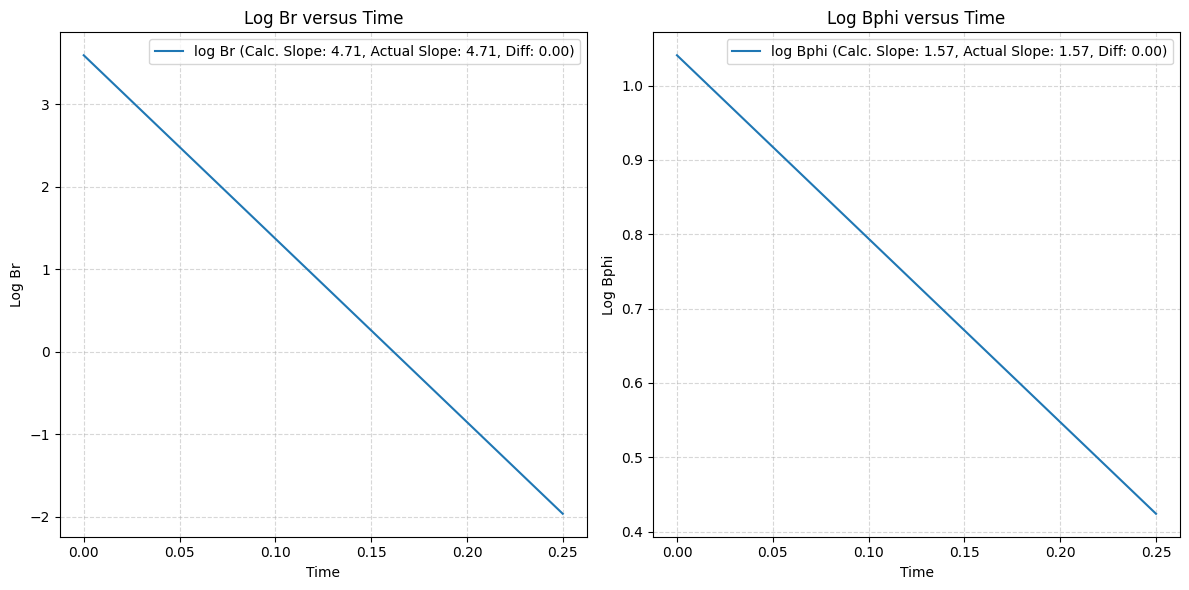

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time, log_Br, label=f'log Br (Calc. Slope: {np.sqrt(-slope_Br):.2f}, Actual Slope: {actual_slope_Br:.2f}, Diff: {difference_Br:.2f})')
plt.xlabel('Time')
plt.ylabel('Log Br')
plt.title('Log Br versus Time')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time, log_Bphi, label=f'log Bphi (Calc. Slope: {np.sqrt(-slope_Bphi):.2f}, Actual Slope: {actual_slope_Bphi:.2f}, Diff: {difference_Bphi:.2f})')
plt.xlabel('Time')
plt.ylabel('Log Bphi')
plt.title('Log Bphi versus Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("seed_10/log_Br_Bphi_vs_time.png")
plt.show()